In [3]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sisl.viz import merge_plots
from sisl.viz.processors.math import normalize
from functools import partial
# To quickly plot the hamiltonian matrix
import plotly.express as px
import cmath
import scipy
from scipy.linalg import ishermitian
from scipy.linalg import schur, eigvals
from matplotlib.colors import LogNorm
import cmocean


In [4]:
cell = sisl.Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR =1.43420), Atom("C", maxR = 1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1]) #, origin=[-5] * 3
)

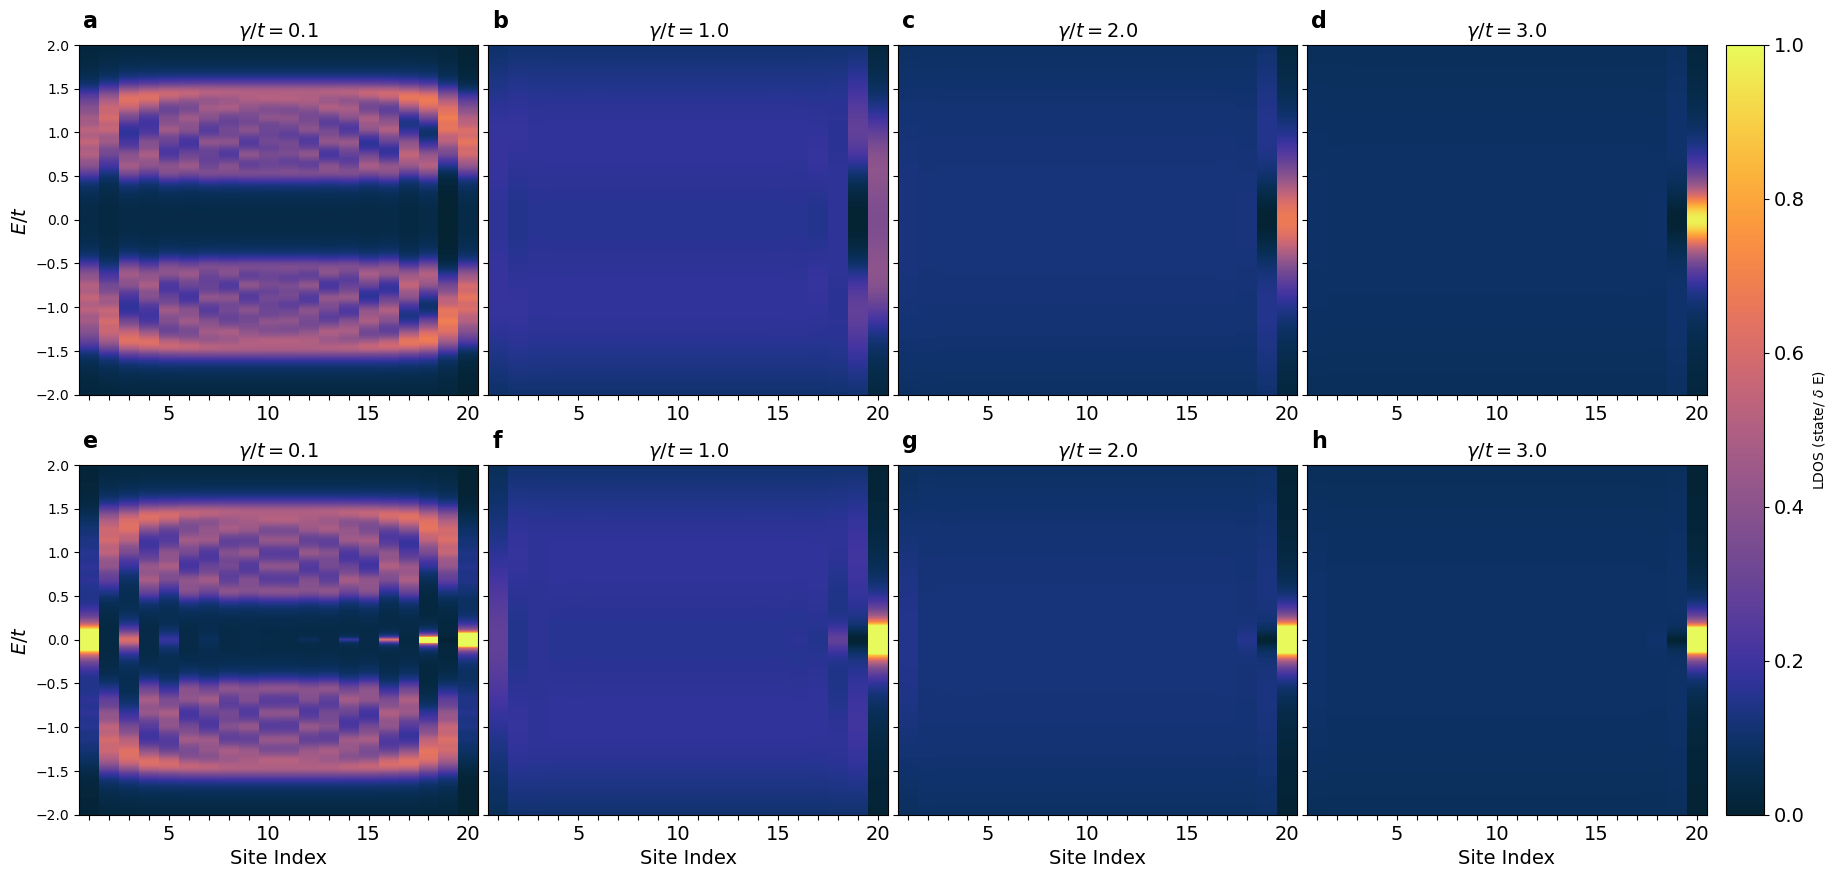

In [5]:
N = 10 
# Topologically trivial parameters
t1_triv = 1.0
t2_triv = 0.5
# Topologically non-trivial parameters
t1_nontriv = 0.5
t2_nontriv = 1.0

#gamma_values = [0.1*t1_triv, 1.0*t1_triv, 2.0*t1_triv]  # Three different gamma_1 values
gamma_values = [0.1, 1.0, 2.0, 3.0]  # Three different gamma_1 values

# Define a suitable energy range for LDOS calculation
energy_min = -2.0
energy_max = 2.0
num_energy_points = 1000
energyGrid = np.linspace(energy_min, energy_max, num_energy_points)

# Helper function to compute LDOS data for given t1, t2 and gamma values
def compute_ldos_for_params(t1, t2, gamma_vals, N, energyGrid):
    ldos_data = []
    for gamma in gamma_vals:
        #cell = sisl.UnitCell([1.0])  # minimal cell, placeholder
        # Build Hamiltonian
        H = sisl.Hamiltonian(cell, dtype='complex')
        # On-site terms
        H[0, 0] = -gamma*1j
        H[1, 1] = -gamma*1j
        # Hoppings
        H[0, 1] = t1 
        H[1, 0] = t1
        H[0, 1, (-1, 0)] = t2
        H[1, 0, (1, 0)] = t2
        H1 = H.tile(N,0)
        # Decoupling bit:
        for k in np.arange(19,2*N):
            H1[k,k] = 0
        H1.set_nsc([1,1,1])
        H2 = H1.Hk().toarray()
        LDOSperSite = np.zeros((2*N, len(energyGrid)))
        for i, E in enumerate(energyGrid):
            denom = E*np.eye(2*N, dtype=complex) - H2
            G_R = np.linalg.inv(denom)
            LDOSperSite[:, i] = -np.imag(np.diag(G_R))/np.pi
        ldos_data.append(LDOSperSite)
    return ldos_data

# Compute LDOS for the trivial case
ldos_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
# Compute LDOS for the non-trivial case
ldos_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Determine global max for colorbar scaling across all six subplots
all_data = ldos_trivial + ldos_nontrivial
global_max = max(np.max(data) for data in all_data)
vmin, vmax = 0, 1 #global_max*0.1

# Now plot
fig, axes = plt.subplots(2, 4, figsize=(25, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)  # Adjust spacing

panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
X_sites, Y_energy = np.meshgrid(np.arange(2*N), energyGrid)

# Top row: Trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    #ax.set_xlabel('Site Index', fontsize=12)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
#    ax.set_xticks(np.arange(2*N))            # from 0 to 19
#    ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)
    ax.text(0.01, 1.10, panel_labels[m], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
            

# Bottom row: Non-trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=14)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)

    ax.set_title(r'$\gamma/ t= {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

   # ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
    ax.text(0.01, 1.10, panel_labels[m+4], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=14)

#plt.suptitle("M = 1")
plt.savefig('fig6Combo3.pdf', format='pdf', bbox_inches='tight')
plt.show()


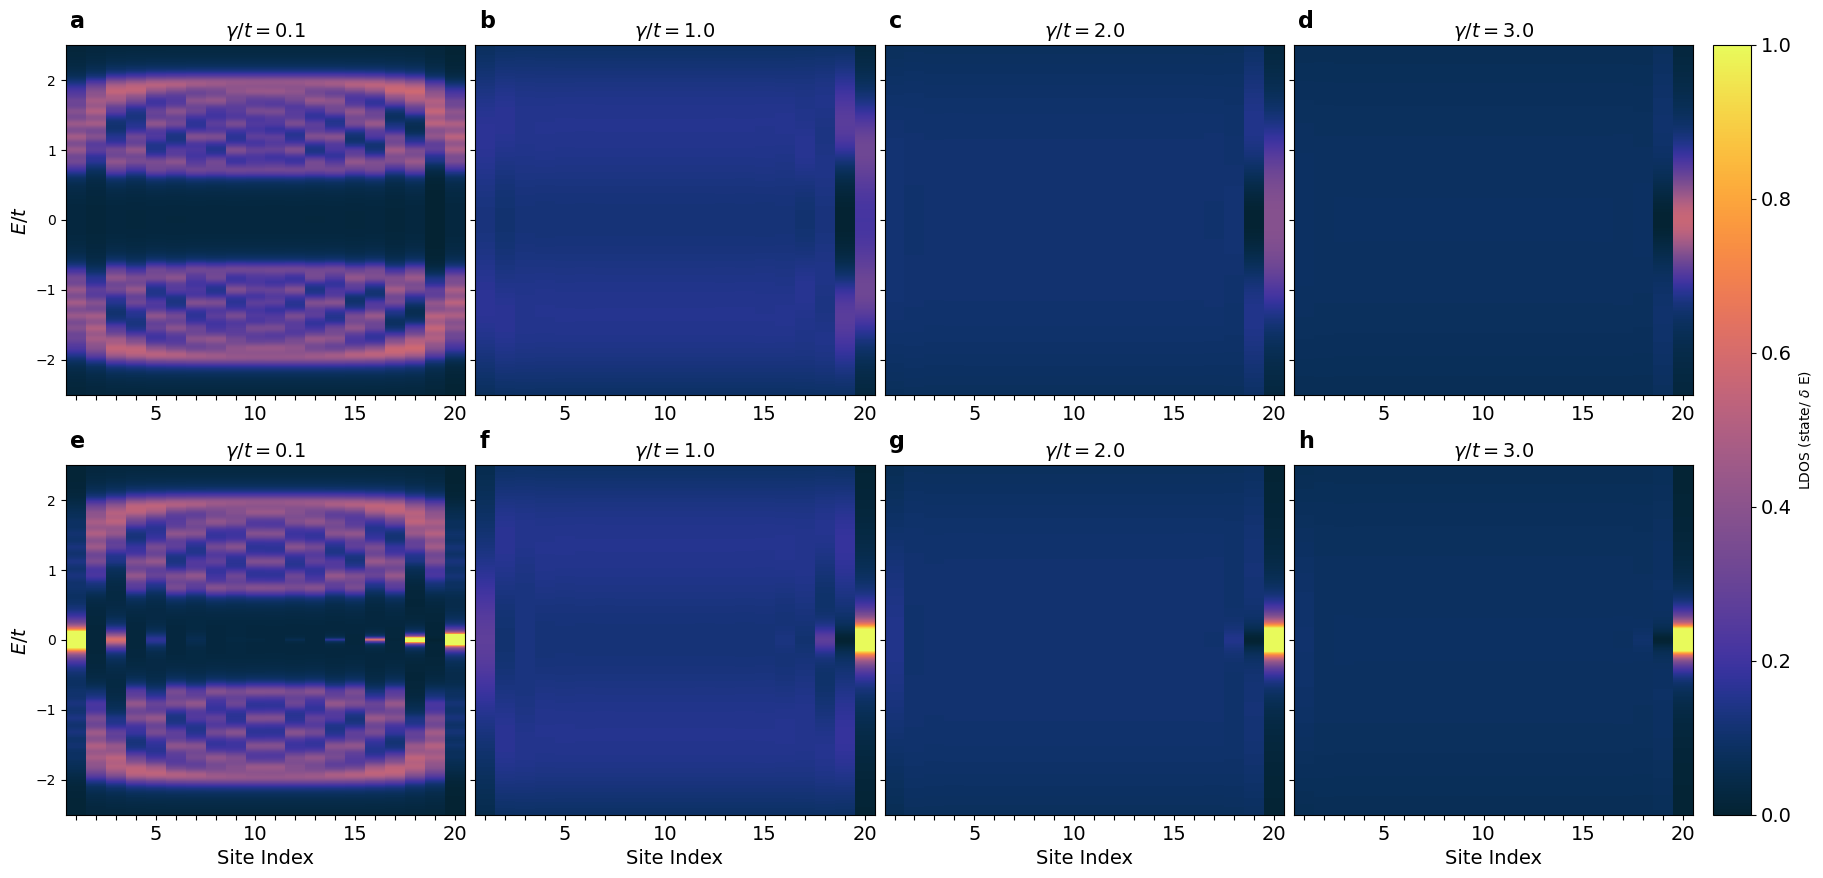

In [46]:
N = 10 
M = 1
# Topologically trivial parameters
t1_triv = 1.333
t2_triv = 0.666
# Topologically non-trivial parameters
t1_nontriv = 0.666
t2_nontriv = 1.333

#gamma_values = [0.1*t1_triv, 1.0*t1_triv, 2.0*t1_triv]  # Three different gamma_1 values
gamma_values = [0.1, 1.0, 2.0, 3.0]  # Three different gamma_1 values

# Define a suitable energy range for LDOS calculation
energy_min = -2.5
energy_max = 2.5
num_energy_points = 1000
energyGrid = np.linspace(energy_min, energy_max, num_energy_points)

# Helper function to compute LDOS data for given t1, t2 and gamma values
def compute_ldos_for_params(t1, t2, gamma_vals, N, energyGrid):
    ldos_data = []
    for gamma in gamma_vals:
        #cell = sisl.UnitCell([1.0])  # minimal cell, placeholder
        # Build Hamiltonian
        H = sisl.Hamiltonian(cell, dtype='complex')
        # On-site terms
        H[0, 0] = -gamma*1j
        H[1, 1] = -gamma*1j
        # Hoppings
        H[0, 1] = t1 
        H[1, 0] = t1
        H[0, 1, (-1, 0)] = t2
        H[1, 0, (1, 0)] = t2
        H1 = H.tile(N,0)
        # Decoupling bit:
        for k in np.arange(2*N - M,2*N):
            H1[k,k] = 0
        H1.set_nsc([1,1,1])
        H2 = H1.Hk().toarray()
        LDOSperSite = np.zeros((2*N, len(energyGrid)))
        for i, E in enumerate(energyGrid):
            denom = E*np.eye(2*N, dtype=complex) - H2
            G_R = np.linalg.inv(denom)
            LDOSperSite[:, i] = -np.imag(np.diag(G_R))/np.pi
        ldos_data.append(LDOSperSite)
    return ldos_data

# Compute LDOS for the trivial case
ldos_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
# Compute LDOS for the non-trivial case
ldos_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Determine global max for colorbar scaling across all six subplots
all_data = ldos_trivial + ldos_nontrivial
global_max = max(np.max(data) for data in all_data)
vmin, vmax = 0, 1 #global_max*0.1

# Now plot
fig, axes = plt.subplots(2, 4, figsize=(25, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)  # Adjust spacing

panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
X_sites, Y_energy = np.meshgrid(np.arange(2*N), energyGrid)

# Top row: Trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    #ax.set_xlabel('Site Index', fontsize=12)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
#    ax.set_xticks(np.arange(2*N))            # from 0 to 19
#    ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)
    ax.text(0.01, 1.10, panel_labels[m], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
            

# Bottom row: Non-trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=14)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)

    ax.set_title(r'$\gamma/ t= {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

   # ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
    ax.text(0.01, 1.10, panel_labels[m+4], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=14)

#plt.suptitle("M = 1")
plt.savefig('fig6Combo4.pdf', format='pdf', bbox_inches='tight')
plt.show()


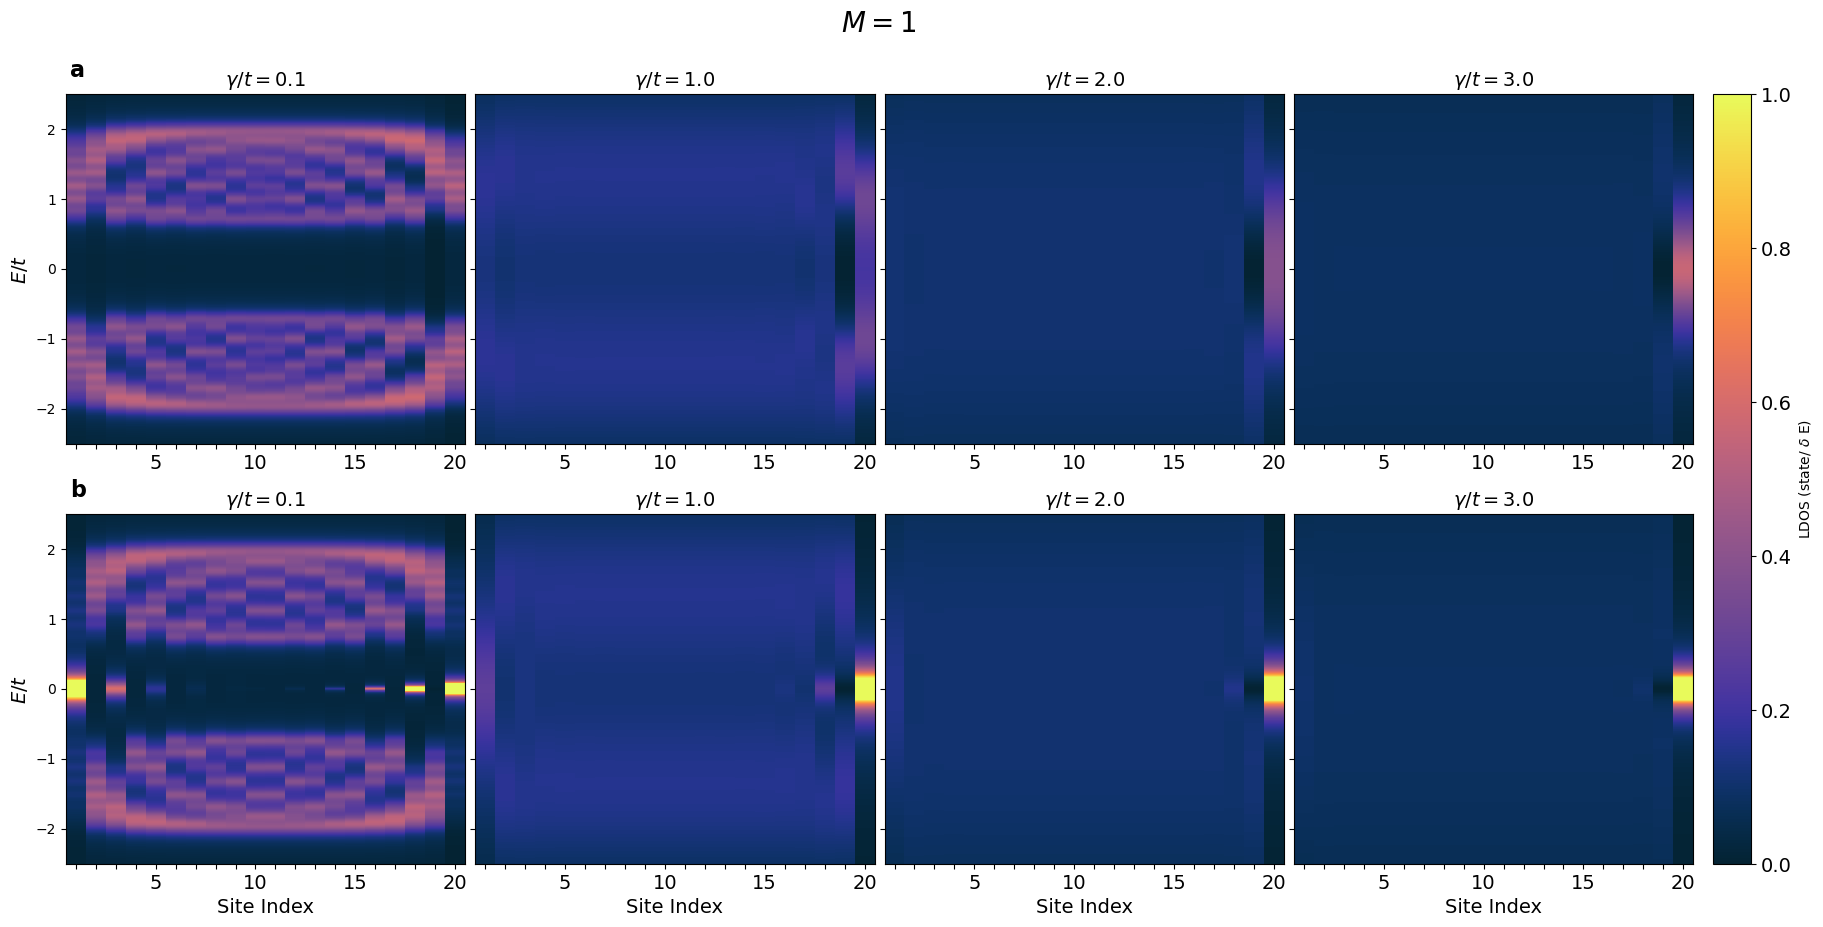

In [47]:
# Now plot
fig, axes = plt.subplots(2, 4, figsize=(25, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)  # Adjust spacing

# Top row: Trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            
    ax.tick_params(axis='both', which='major', labelsize=10)
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    # Only add label `a` for the first subplot in the top row
    if m == 0:
        ax.text(0.01, 1.10, 'a', transform=ax.transAxes, 
                fontsize=16, fontweight='bold', va='top', ha='left')

# Bottom row: Non-trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=14)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma/ t= {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            
    ax.tick_params(axis='both', which='major', labelsize=10)
    custom_labels = [5, 10, 15, 20]  
    all_ticks = np.arange(2*N)  
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    # Only add label `b` for the first subplot in the bottom row
    if m == 0:
        ax.text(0.01, 1.10, 'b', transform=ax.transAxes, 
                fontsize=16, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=14)

# Add the label $M = 1$ between panels 2 and 3
fig.text(0.45, 0.95, "$M = 1$", ha='center', va='center', fontsize=20, fontweight='bold')

# Save and show the figure
plt.savefig('fig6Combo4.pdf', format='pdf', bbox_inches='tight')
plt.show()


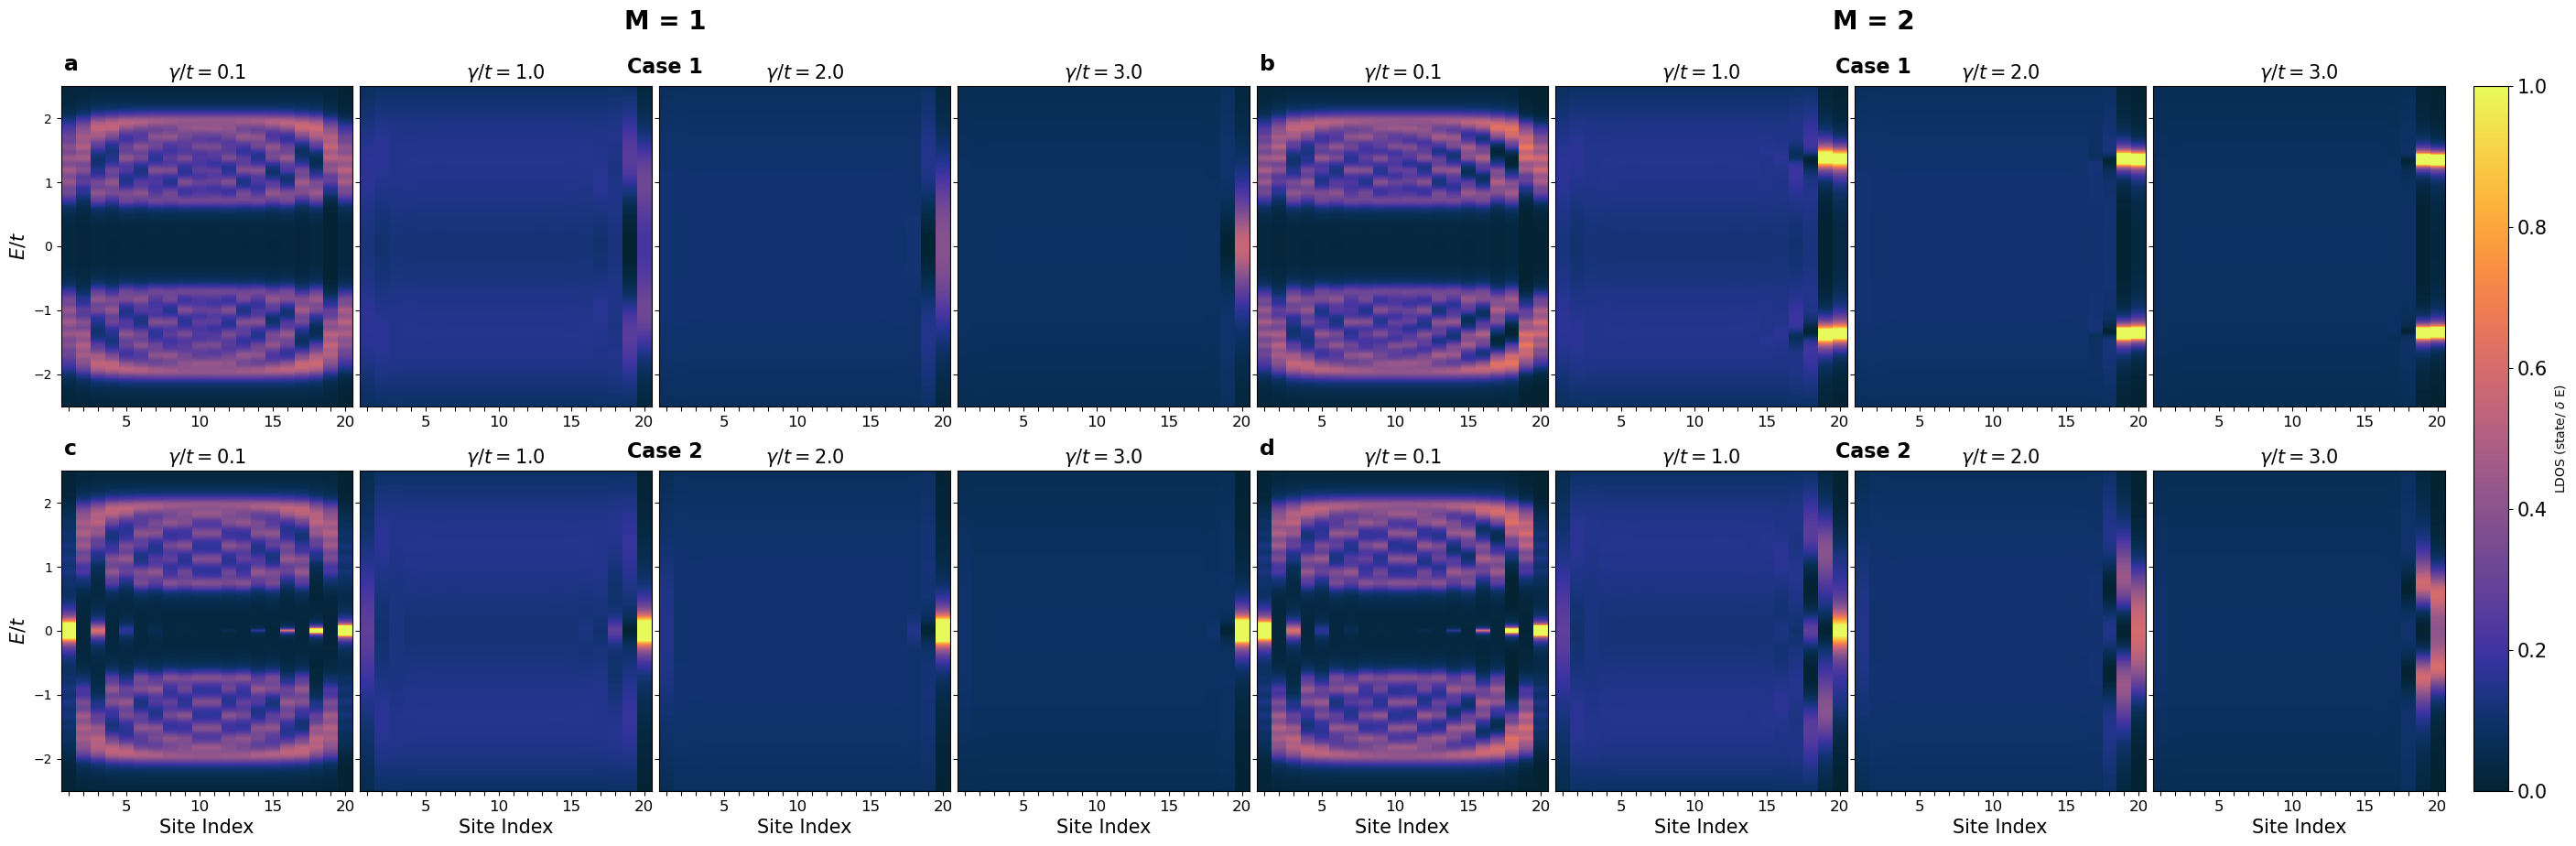

In [49]:
# Compute LDOS for M = 2
M = 2
ldos_M2_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
ldos_M2_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Create a larger figure with 2 rows and 8 columns
fig, axes = plt.subplots(2, 8, figsize=(40, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)

X_sites, Y_energy = np.meshgrid(np.arange(2 * N), energyGrid)

# Custom tick positions and labels
custom_ticks = np.arange(2 * N) + 1  # Ticks from 1 to 20
custom_labels = [str(x) if x in [5, 10, 15, 20] else "" for x in custom_ticks]

# Panel labels
panel_labels = ['a', 'b', 'c', 'd']
label_positions = [(0, 0), (0, 4), (1, 0), (1, 4)]  # (row, col) positions for labeled panels

# Plot M = 1 data on the left half
for m, gamma in enumerate(gamma_values):
    # Top row: Trivial case
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=15)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=12)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=15)
    if (0, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m))], transform=ax.transAxes,
                fontsize=17, fontweight='bold', va='top', ha='left')  # Label only designated panels

    # Bottom row: Non-trivial case
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=15)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=15)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=12)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=15)
    if (1, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m))], transform=ax.transAxes,
                fontsize=17, fontweight='bold', va='top', ha='left')  # Label only designated panels

# Plot M = 2 data on the right half
for m, gamma in enumerate(gamma_values):
    # Top row: Trivial case
    LDOSperSite = ldos_M2_trivial[m]
    ax = axes[0, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=12)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=15)
    if (0, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m + 4))], transform=ax.transAxes,
                fontsize=17, fontweight='bold', va='top', ha='left')  # Label only designated panels

    # Bottom row: Non-trivial case
    LDOSperSite = ldos_M2_nontrivial[m]
    ax = axes[1, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=15)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=12)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=15)
    if (1, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m + 4))], transform=ax.transAxes,
                fontsize=17, fontweight='bold', va='top', ha='left')  # Label only designated panels

# Add global titles for M = 1 and M = 2
fig.text(0.29, 0.95, "M = 1", ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.62, 0.95, "M = 2", ha='center', va='center', fontsize=20, fontweight='bold')

fig.text(0.29, 0.9, "Case 1", ha='center', va='center', fontsize=16, fontweight='bold')
fig.text(0.62, 0.9, "Case 1", ha='center', va='center', fontsize=16, fontweight='bold')

fig.text(0.29, 0.48, "Case 2", ha='center', va='center', fontsize=16, fontweight='bold')
fig.text(0.62, 0.48, "Case 2", ha='center', va='center', fontsize=16, fontweight='bold')


# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=15)

# Save and show the figure
plt.savefig('figLDOS_1-2.pdf', format='pdf', bbox_inches='tight')
plt.show()


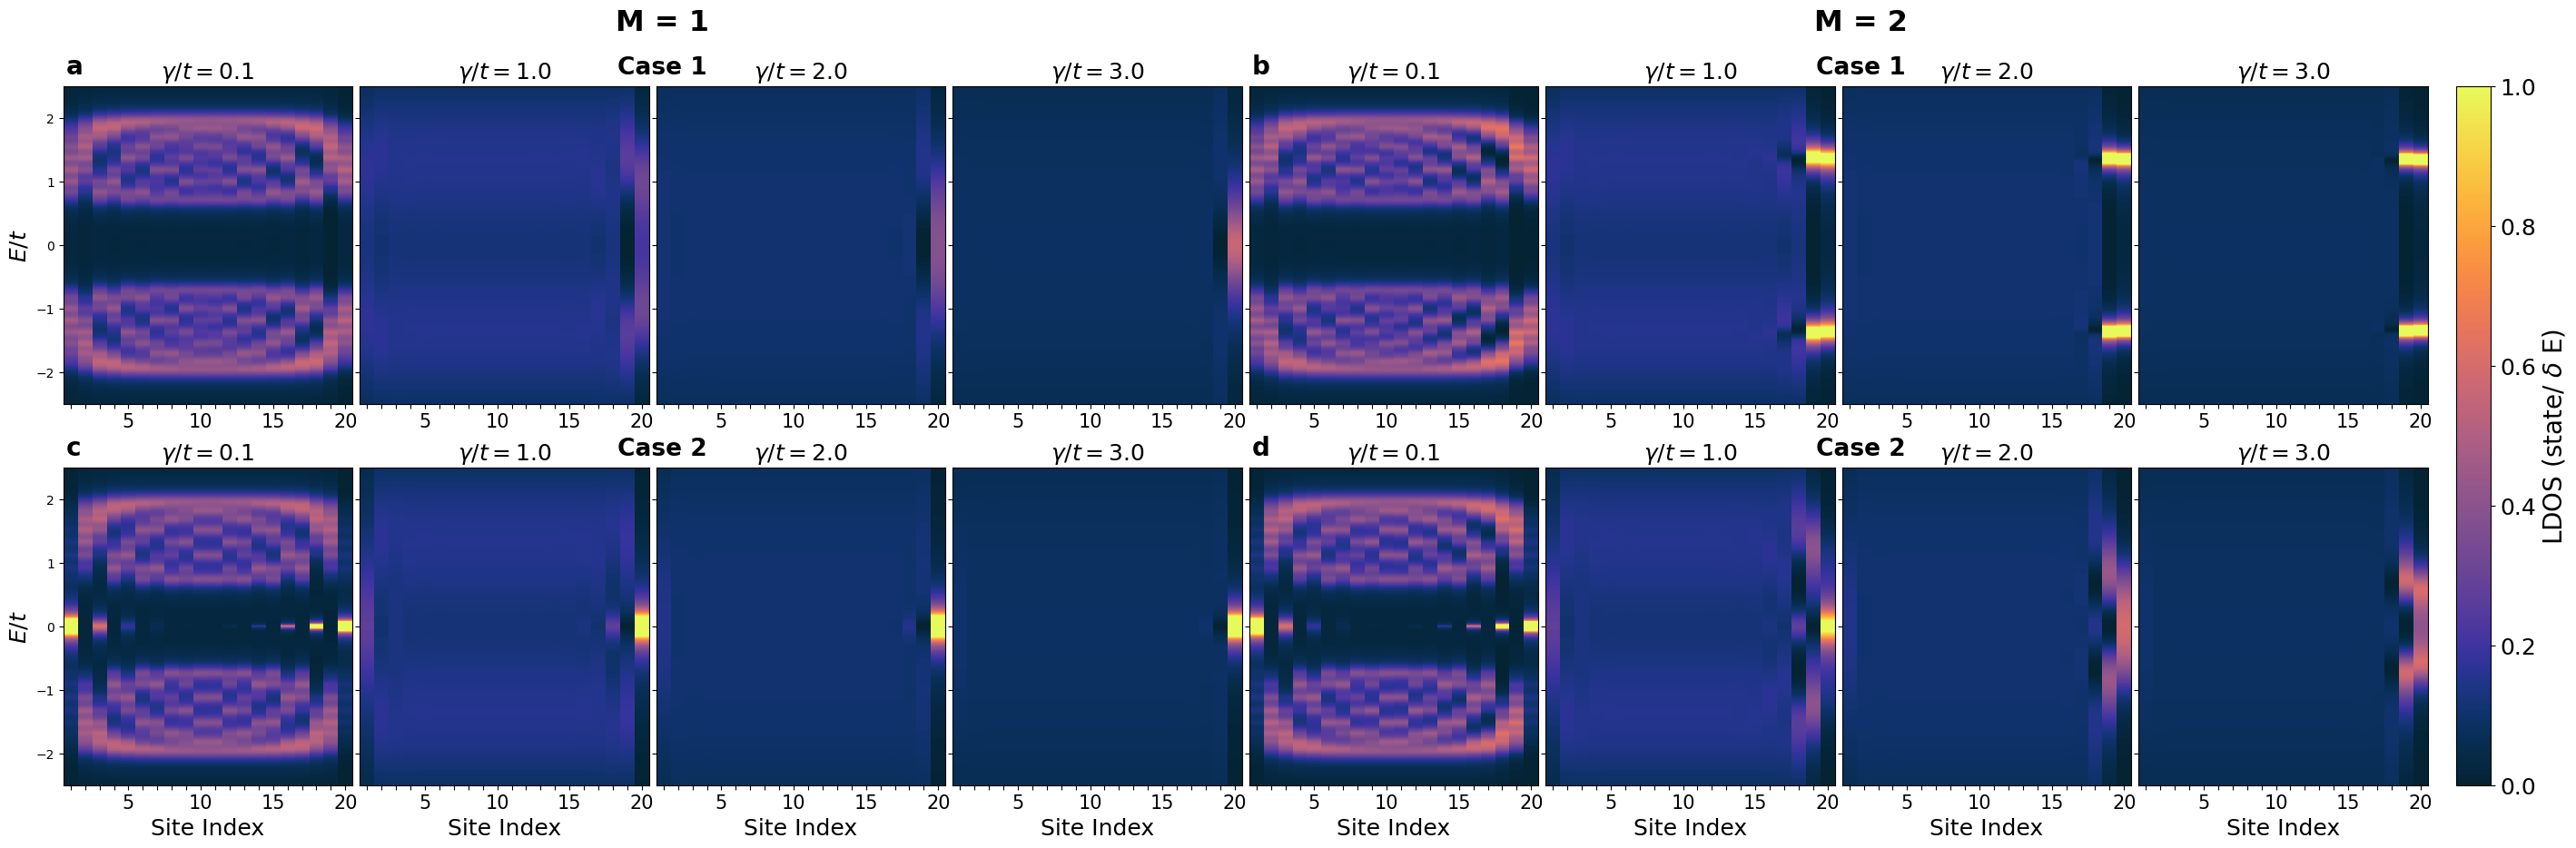

In [ ]:
# Compute LDOS for M = 2
M = 2
ldos_M2_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
ldos_M2_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Create a larger figure with 2 rows and 8 columns
fig, axes = plt.subplots(2, 8, figsize=(40, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)

X_sites, Y_energy = np.meshgrid(np.arange(2 * N), energyGrid)

# Custom tick positions and labels
custom_ticks = np.arange(2 * N) + 1  # Ticks from 1 to 20
custom_labels = [str(x) if x in [5, 10, 15, 20] else "" for x in custom_ticks]

# Panel labels
panel_labels = ['a', 'b', 'c', 'd']
label_positions = [(0, 0), (0, 4), (1, 0), (1, 4)]  # (row, col) positions for labeled panels

# Plot M = 1 data on the left half
for m, gamma in enumerate(gamma_values):
    # Top row: Trivial case
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=18)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=15)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=18)
    if (0, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m))], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left')  # Label only designated panels

    # Bottom row: Non-trivial case
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=18)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=18)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=15)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=18)
    if (1, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m))], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left')  # Label only designated panels

# Plot M = 2 data on the right half
for m, gamma in enumerate(gamma_values):
    # Top row: Trivial case
    LDOSperSite = ldos_M2_trivial[m]
    ax = axes[0, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=15)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=18)
    if (0, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m + 4))], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left')  # Label only designated panels

    # Bottom row: Non-trivial case
    LDOSperSite = ldos_M2_nontrivial[m]
    ax = axes[1, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=18)
    ax.set_xticks(custom_ticks - 1)  # Adjust for zero-based indexing
    ax.set_xticklabels(custom_labels, fontsize=15)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=18)
    if (1, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m + 4))], transform=ax.transAxes,
                fontsize=20, fontweight='bold', va='top', ha='left')  # Label only designated panels

# Add global titles for M = 1 and M = 2
fig.text(0.29, 0.95, "M = 1", ha='center', va='center', fontsize=23, fontweight='bold')
fig.text(0.62, 0.95, "M = 2", ha='center', va='center', fontsize=23, fontweight='bold')

fig.text(0.29, 0.9, "Case 1", ha='center', va='center', fontsize=19, fontweight='bold')
fig.text(0.62, 0.9, "Case 1", ha='center', va='center', fontsize=19, fontweight='bold')

fig.text(0.29, 0.48, "Case 2", ha='center', va='center', fontsize=19, fontweight='bold')
fig.text(0.62, 0.48, "Case 2", ha='center', va='center', fontsize=19, fontweight='bold')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.set_label('LDOS (state/ $\delta$ E)', fontsize=18)  # Set colorbar label font size to 20
cbar.ax.tick_params(labelsize=18)

# Save and show the figure
plt.savefig('fig_combined_M1_M2.pdf', format='pdf', bbox_inches='tight')
plt.show()


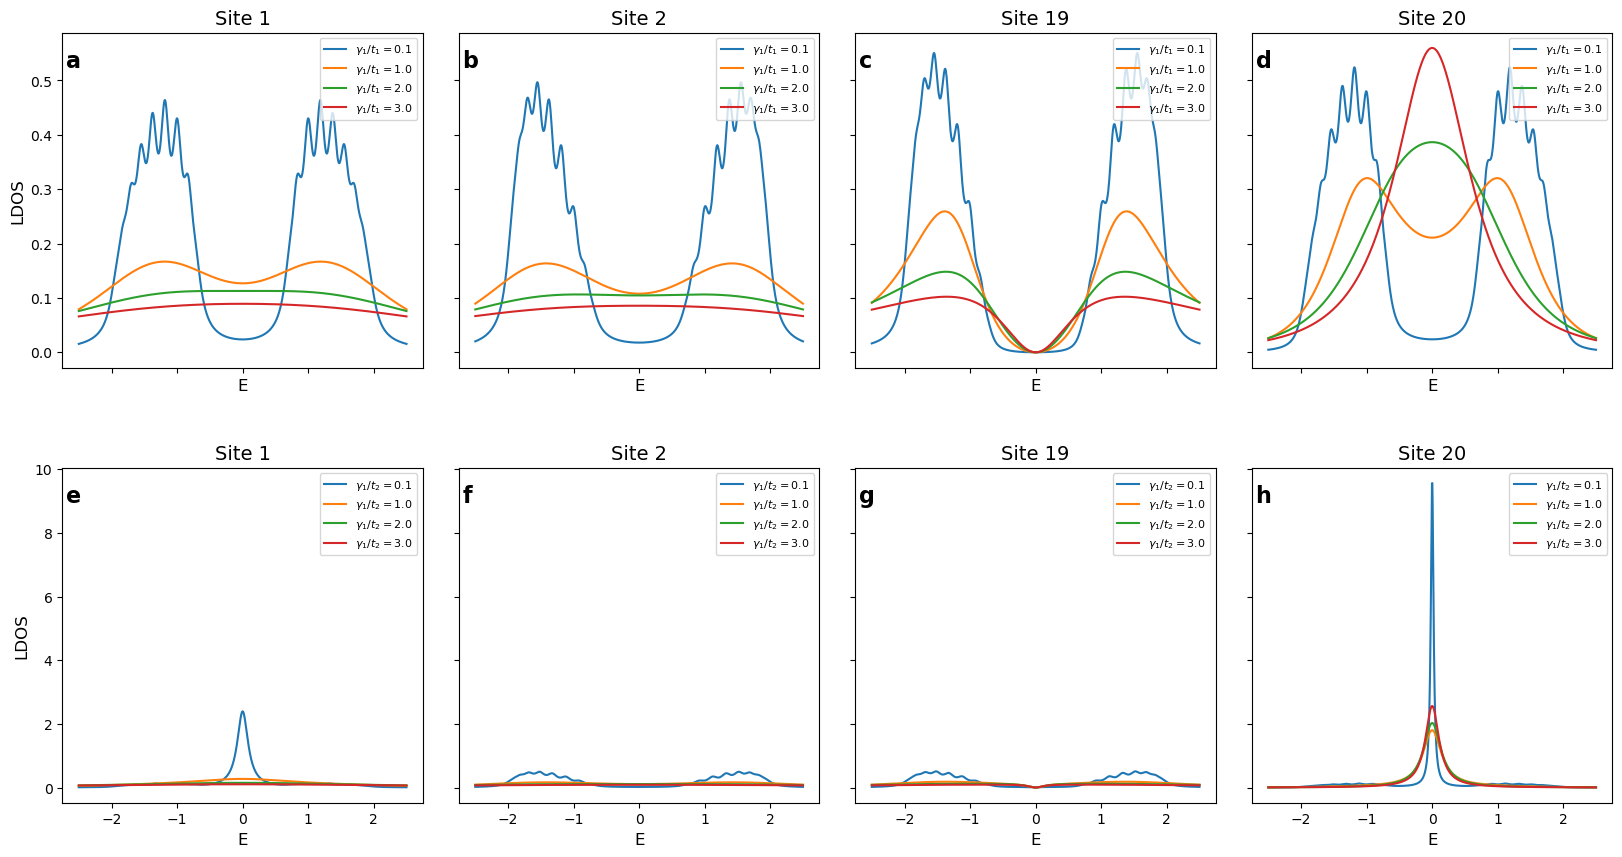

In [8]:

# Assuming the LDOS data is already computed (ldos_trivial, ldos_nontrivial)
sites_to_plot = [0, 1, 18, 19]
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1, hspace=0.3)  # Adjust spacing

# Top row: Trivial case
for i, site_index in enumerate(sites_to_plot):
    ax = axes[0, i]
    for m, gamma in enumerate(gamma_values):
        LDOSperSite = ldos_trivial[m]
        ax.plot(energyGrid, LDOSperSite[site_index, :], label=r'$\gamma_1 / t_1 = {:.1f}$'.format(gamma))
    ax.set_xlabel('E', fontsize=12)
    if i == 0:
        ax.set_ylabel('LDOS', fontsize=12)
    ax.legend(fontsize=8, loc='upper right')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title(f"Site {site_index + 1}", fontsize=14)
    ax.text(0.01, 0.95, panel_labels[i], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

# Bottom row: Non-trivial case
for i, site_index in enumerate(sites_to_plot):
    ax = axes[1, i]
    for m, gamma in enumerate(gamma_values):
        LDOSperSite = ldos_nontrivial[m]
        ax.plot(energyGrid, LDOSperSite[site_index, :], label=r'$\gamma_1 / t_2 = {:.1f}$'.format(gamma))
    ax.set_xlabel('E', fontsize=12)
    if i == 0:
        ax.set_ylabel('LDOS', fontsize=12)
    ax.legend(fontsize=8, loc='upper right')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title(f"Site {site_index + 1}", fontsize=14)
    ax.text(0.01, 0.95, panel_labels[i + 4], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

plt.savefig('siteLDOS-decoupled1.pdf', format='pdf', bbox_inches='tight')
plt.show()
